# Seattle PD 911 Dispatch Forecaster
by Group 5: Samantha Baradas, James Calendario, & Jaime Pastor

NOTE: Notebook was updated to include feedback from presentation. New features are the addition of ARIMA model as a baseline and the additional cell to test 52 weeks in the past for training the XGBoost Regressor. Along with the addition of the ARIMA model, changes were made to how the dataset aggregated the crime per week, specifically what index was assigned to the aggregate, which affected the numerical values of the dataset but our assertions remain the same.

# Introduction

According to a Seattle Times article (Westneat, 2021), it was revealed that crime in 2020 had seen all time highs amid the pandemic, rising gun violence and campaigns to defund the police. The article showed that Seattle homicides increased 68%, a 26 year high, arson also set a modern record, nearly doubling in a year yet total arrests made for murders are only 29% in 2020. With this, using a public dataset from Kaggle on the Seattle Police Department 911 Incident Response, the objective of our project is to build a model that could forecast the total amount of weekly 911 dispatch calls and using the results be able to give recommendations on manpower and resource allotment of the seattle police department.

Link to Kaggle dataset: https://www.kaggle.com/sohier/seattle-police-department-911-incident-response

# List of Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

import shap
%matplotlib inline

C:\Users\jarpj\miniconda3\envs\datasci\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
crime_df = pd.read_csv('data/Seattle_Police_Department_911_Incident_Response.csv')
crime_df.head()

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


,CAD CDW ID,CAD Event Number,General Offense Number,Event Clearance Code,Event Clearance Description,Event Clearance SubGroup,Event Clearance Group,Event Clearance Date,Hundred Block Location,District/Sector,Zone/Beat,Census Tract,Longitude,Latitude,Incident Location,Initial Type Description,Initial Type Subgroup,Initial Type Group,At Scene Time
0,﻿15736,10000246357,2010246357,242.0,FIGHT DISTURBANCE,DISTURBANCES,DISTURBANCES,07/17/2010 08:49:00 PM,3XX BLOCK OF PINE ST,M,M2,8100.2001,-122.338147,47.610975,"(47.610975163, -122.338146748)",NaN,NaN,NaN,NaN
1,15737,10000246471,2010246471,65.0,THEFT - MISCELLANEOUS,THEFT,OTHER PROPERTY,07/17/2010 08:50:00 PM,36XX BLOCK OF DISCOVERY PARK BLVD,Q,Q1,5700.1012,-122.404613,47.658325,"(47.658324899, -122.404612874)",NaN,NaN,NaN,NaN
2,15738,10000246255,2010246255,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS","NUISANCE, MISCHIEF",07/17/2010 08:55:00 PM,21XX BLOCK OF 3RD AVE,M,M2,7200.2025,-122.342843,47.613551,"(47.613551471, -122.342843234)",NaN,NaN,NaN,NaN
3,15739,10000246473,2010246473,460.0,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,07/17/2010 09:00:00 PM,7XX BLOCK OF ROY ST,D,D1,7200.1002,-122.341847,47.625401,"(47.625401388, -122.341846999)",NaN,NaN,NaN,NaN
4,15740,10000246330,2010246330,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS","NUISANCE, MISCHIEF",07/17/2010 09:00:00 PM,9XX BLOCK OF ALOHA ST,D,D1,6700.1009,-122.339709,47.627425,"(47.627424837, -122.339708605)",NaN,NaN,NaN,NaN


The following are the features of the dataset along with short descriptions of what each feature means.

1. CAD CDW ID - Computer Aided Dispatch (CAD) ID for 911 Response
1. CAD Event Number - ID for CAD Event
1. General Offense Number - Combination of CAD Event Number and Current Year
1. Event Clearance Code - Numeric Code for Type of Event
1. Event Clearance Description - Description of Event
1. Event Clearance SubGroup - Sub Group Classification of Event
1. Event Clearance Group - Group Classification of Event
1. Event Clearance Date - Date of Dispatch for Event
1. Hundred Block Location - Closest Street in One Hundred Location
1. District/Sector - District/Sector of Event
1. Zone/Beat - Part of District/Sector Assigned to Police Precinct
1. Census Tract - Defined region for census taking
1. Longitude - Longitude value of incident
1. Latitude - Latitude value of incident
1. Incident Location - Geolocation value (Combined Latitude and Longitude values)
1. Initial Type Description - Initial Description of Event
1. Initial Type SubGroup - Initial Sub Group Classification of Event
1. Initial Type Group - Group Classification of Event
1. At Scene Time - Reported time of incident

# Data Pre-Processing

Upon first inspection of the dataset, we can see that there are a lot of features which can be used to forecast crime. However, these features are not easily read by machines. Therefore, we shall be performing some cleaning first before exploring the data.

In [3]:
# Checking for NaN values
crime_df.isna().sum()

CAD CDW ID                           0
CAD Event Number                     0
General Offense Number               0
Event Clearance Code             11418
Event Clearance Description      11419
Event Clearance SubGroup         11419
Event Clearance Group            11419
Event Clearance Date             11584
Hundred Block Location            3487
District/Sector                   1169
Zone/Beat                            1
Census Tract                      2764
Longitude                            1
Latitude                             1
Incident Location                    1
Initial Type Description        577813
Initial Type Subgroup           577813
Initial Type Group              577813
At Scene Time                  1023030
dtype: int64

Seeing as there were multiple NaN values found in the Initial Type Description, Subgroup, and Group features along with the At Scene Time feature, we found it best to drop these features instead, which will be done in a future cell. We also found that the value 99 was substitue for some NaN values as well, so we replaced them with real NaN values for ease of cleaning.

We also agreed as a group that the features we will focus on are `District/Sector`, `Event Clearance Date`, and `Event Clearance Group` to help forecast crime.

In [4]:
# 99 was used in replacemnt for NaN values
crime_df['District/Sector'] = crime_df['District/Sector'].replace('99', np.NaN)
crime_df.loc[crime_df['District/Sector'] == '99']

,CAD CDW ID,CAD Event Number,General Offense Number,Event Clearance Code,Event Clearance Description,Event Clearance SubGroup,Event Clearance Group,Event Clearance Date,Hundred Block Location,District/Sector,Zone/Beat,Census Tract,Longitude,Latitude,Incident Location,Initial Type Description,Initial Type Subgroup,Initial Type Group,At Scene Time


As seen earlier, there were around 11k NaN values for dates. It is better to drop these rows than filling them as it may disrupt the integrity of the dataset.

In [5]:
# Event Clearance Date values were string objects. Converted it to datetime objects. Filling NaN values with most frequent/mode dates

new_dates = pd.to_datetime(crime_df['Event Clearance Date'])
new_dates = new_dates.dropna()
new_dates.isna().sum()

0

In [6]:
# converting data into Year - Week format for easier aggregation

crime_df['dates'] = new_dates
crime_df['week_date'] = crime_df['dates'].dt.strftime('%Y-W%U')
crime_df

,CAD CDW ID,CAD Event Number,General Offense Number,Event Clearance Code,Event Clearance Description,Event Clearance SubGroup,Event Clearance Group,Event Clearance Date,Hundred Block Location,District/Sector,...,Census Tract,Longitude,Latitude,Incident Location,Initial Type Description,Initial Type Subgroup,Initial Type Group,At Scene Time,dates,week_date
0,﻿15736,10000246357,2010246357,242.0,FIGHT DISTURBANCE,DISTURBANCES,DISTURBANCES,07/17/2010 08:49:00 PM,3XX BLOCK OF PINE ST,M,...,8100.2001,-122.338147,47.610975,"(47.610975163, -122.338146748)",NaN,NaN,NaN,NaN,2010-07-17 20:49:00,2010-W28
1,15737,10000246471,2010246471,65.0,THEFT - MISCELLANEOUS,THEFT,OTHER PROPERTY,07/17/2010 08:50:00 PM,36XX BLOCK OF DISCOVERY PARK BLVD,Q,...,5700.1012,-122.404613,47.658325,"(47.658324899, -122.404612874)",NaN,NaN,NaN,NaN,2010-07-17 20:50:00,2010-W28
2,15738,10000246255,2010246255,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS","NUISANCE, MISCHIEF",07/17/2010 08:55:00 PM,21XX BLOCK OF 3RD AVE,M,...,7200.2025,-122.342843,47.613551,"(47.613551471, -122.342843234)",NaN,NaN,NaN,NaN,2010-07-17 20:55:00,2010-W28
3,15739,10000246473,2010246473,460.0,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,07/17/2010 09:00:00 PM,7XX BLOCK OF ROY ST,D,...,7200.1002,-122.341847,47.625401,"(47.625401388, -122.341846999)",NaN,NaN,NaN,NaN,2010-07-17 21:00:00,2010-W28
4,15740,10000246330,2010246330,250.0,"MISCHIEF, NUISANCE COMPLAINTS","NUISANCE, MISCHIEF COMPLAINTS","NUISANCE, MISCHIEF",07/17/2010 09:00:00 PM,9XX BLOCK OF ALOHA ST,D,...,6700.1009,-122.339709,47.627425,"(47.627424837, -122.339708605)",NaN,NaN,NaN,NaN,2010-07-17 21:00:00,2010-W28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433848,2076150,17000311514,2017311514,177.0,LIQUOR VIOLATION - INTOXICATED PERSON,LIQUOR VIOLATIONS,LIQUOR VIOLATIONS,08/22/2017 11:39:41 PM,5XX BLOCK OF 3 AV,K,...,8100.2043,-122.331085,47.602413,"(47.602413, -122.331085)",DETOX - REQUEST FOR,LIQUOR VIOLATIONS,LIQUOR VIOLATIONS,NaN,2017-08-22 23:39:41,2017-W34
1433849,2076151,17000311508,2017311508,177.0,LIQUOR VIOLATION - INTOXICATED PERSON,LIQUOR VIOLATIONS,LIQUOR VIOLATIONS,08/22/2017 11:35:49 PM,3XX BLOCK OF 2 AV S,K,...,9200.2028,-122.330810,47.600464,"(47.600464, -122.33081)",DETOX - REQUEST FOR,LIQUOR VIOLATIONS,LIQUOR VIOLATIONS,NaN,2017-08-22 23:35:49,2017-W34
1433850,2076156,17000311347,2017311347,192.0,MISDEMEANOR WARRANT SERVICE,WARRANT CALLS,ARREST,08/22/2017 11:27:07 PM,5XX BLOCK OF PINE ST,M,...,8200.1003,-122.335930,47.611904,"(47.611904, -122.33593)",SHOPLIFT - THEFT,SHOPLIFTING,THEFT,08/22/2017 09:13:01 PM,2017-08-22 23:27:07,2017-W34
1433851,2076157,17000311332,2017311332,281.0,SUSPICIOUS VEHICLE,SUSPICIOUS CIRCUMSTANCES,SUSPICIOUS CIRCUMSTANCES,08/22/2017 11:40:09 PM,67XX BLOCK OF MARS AV S,S,...,11002.3010,-122.302210,47.541910,"(47.54191, -122.30221)","SUSPICIOUS PERSON, VEHICLE OR INCIDENT",SUSPICIOUS CIRCUMSTANCES,SUSPICIOUS CIRCUMSTANCES,08/22/2017 09:06:27 PM,2017-08-22 23:40:09,2017-W34


In [7]:
# Dropping the following due to too much NaN
crime_df = crime_df.drop(['Initial Type Description', 'Initial Type Subgroup', 'Initial Type Group', 'At Scene Time'], axis=1)

# Dropping due to redundancies with other features
crime_df = crime_df.drop(['Zone/Beat', 'Hundred Block Location', 'Incident Location', 'Longitude', 'Latitude', 'Census Tract', 'Event Clearance Code', 'Event Clearance Description', 'Event Clearance SubGroup', 'Event Clearance Date'], axis=1)

# Dropping due to being IDs
crime_df = crime_df.drop(['General Offense Number', 'CAD Event Number', 'CAD CDW ID'], axis=1)
crime_df.isna().sum()

Event Clearance Group    11419
District/Sector           2686
dates                    11584
week_date                11584
dtype: int64

In [8]:
# Isolating dates for ease of data imputation
dates = crime_df[['dates', 'week_date']]
dates

crime_df = crime_df.drop(['dates', 'week_date'], axis=1)

In [9]:
# Renaming Event Clearance Group and District/Sector's names to more concise terms
crime_df['call_type'] = crime_df['Event Clearance Group']
crime_df['district'] = crime_df['District/Sector']
crime_df = crime_df.drop(['Event Clearance Group', 'District/Sector'], axis=1)
crime_df

,call_type,district
0,DISTURBANCES,M
1,OTHER PROPERTY,Q
2,"NUISANCE, MISCHIEF",M
3,TRAFFIC RELATED CALLS,D
4,"NUISANCE, MISCHIEF",D
...,...,...
1433848,LIQUOR VIOLATIONS,K
1433849,LIQUOR VIOLATIONS,K
1433850,ARREST,M
1433851,SUSPICIOUS CIRCUMSTANCES,S


We set up our Categorical Imputers as well as our One Hot Encoders to make the dataset easier to understand for the models instead of feeding it the raw categorical values.

In [10]:
# Data Imputation

categorical_imputer = Pipeline(
    steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown="ignore", sparse=False))
    ]
)

In [11]:
categorical_features = crime_df.select_dtypes(include='object').columns.tolist()

num_cat_imputer = ColumnTransformer(
    transformers = [
        ('categorical', categorical_imputer, categorical_features)
    ]
)

In [12]:
imputed = num_cat_imputer.fit_transform(crime_df)
cols = num_cat_imputer.transformers_[0][1][1].get_feature_names_out(categorical_features).tolist()

print(cols)
new_data = pd.DataFrame(imputed, columns=cols)
new_data

['call_type_ACCIDENT INVESTIGATION', 'call_type_ANIMAL COMPLAINTS', 'call_type_ARREST', 'call_type_ASSAULTS', 'call_type_AUTO THEFTS', 'call_type_BEHAVIORAL HEALTH', 'call_type_BIKE', 'call_type_BURGLARY', 'call_type_CAR PROWL', 'call_type_DISTURBANCES', 'call_type_DRIVE BY (NO INJURY)', 'call_type_FAILURE TO REGISTER (SEX OFFENDER)', 'call_type_FALSE ALACAD', 'call_type_FALSE ALARMS', 'call_type_FRAUD CALLS', 'call_type_HARBOR CALLS', 'call_type_HAZARDS', 'call_type_HOMICIDE', 'call_type_LEWD CONDUCT', 'call_type_LIQUOR VIOLATIONS', 'call_type_MENTAL HEALTH', 'call_type_MISCELLANEOUS MISDEMEANORS', 'call_type_MOTOR VEHICLE COLLISION INVESTIGATION', 'call_type_NARCOTICS COMPLAINTS', 'call_type_NUISANCE, MISCHIEF', 'call_type_NUISANCE, MISCHIEF ', 'call_type_OTHER PROPERTY', 'call_type_OTHER VICE', 'call_type_PERSON DOWN/INJURY', 'call_type_PERSONS - LOST, FOUND, MISSING', 'call_type_PROPERTY - MISSING, FOUND', 'call_type_PROPERTY DAMAGE', 'call_type_PROSTITUTION', 'call_type_PROWLER', 

,call_type_ACCIDENT INVESTIGATION,call_type_ANIMAL COMPLAINTS,call_type_ARREST,call_type_ASSAULTS,call_type_AUTO THEFTS,call_type_BEHAVIORAL HEALTH,call_type_BIKE,call_type_BURGLARY,call_type_CAR PROWL,call_type_DISTURBANCES,...,district_K,district_L,district_M,district_N,district_O,district_Q,district_R,district_S,district_U,district_W
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1433849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1433850,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1433851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
cleaned_crime_df = pd.concat([new_data, dates], axis=1)
cleaned_crime_df

,call_type_ACCIDENT INVESTIGATION,call_type_ANIMAL COMPLAINTS,call_type_ARREST,call_type_ASSAULTS,call_type_AUTO THEFTS,call_type_BEHAVIORAL HEALTH,call_type_BIKE,call_type_BURGLARY,call_type_CAR PROWL,call_type_DISTURBANCES,...,district_M,district_N,district_O,district_Q,district_R,district_S,district_U,district_W,dates,week_date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-07-17 20:49:00,2010-W28
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2010-07-17 20:50:00,2010-W28
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-07-17 20:55:00,2010-W28
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-07-17 21:00:00,2010-W28
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-07-17 21:00:00,2010-W28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-08-22 23:39:41,2017-W34
1433849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-08-22 23:35:49,2017-W34
1433850,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-08-22 23:27:07,2017-W34
1433851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017-08-22 23:40:09,2017-W34


In [14]:
# Creation of csv file as a backup of the cleaned dataset
# cleaned_crime_df.to_csv('cleaned_crime_data.csv')

As this problem is a forecasting/regression problem, we deemed it best to aggregate the dataset on a per week basis (resampling it using the `W` rule), and getting the total sum of crimes per week so that our model will be trained to forecast on a per week basis.

In [15]:
# Aggregating through resampling function of pandas for compatibility with ARIMA tests.
# Summation of 911 responses using call_type feature. District feature ignore to not inflate aggregate values.

aggregated_sum_per_week = pd.concat([cleaned_crime_df.filter(regex='call_type'), cleaned_crime_df['dates']], axis=1).set_index('dates').resample(rule='W').sum()
aggregated_sum_per_week

,call_type_ACCIDENT INVESTIGATION,call_type_ANIMAL COMPLAINTS,call_type_ARREST,call_type_ASSAULTS,call_type_AUTO THEFTS,call_type_BEHAVIORAL HEALTH,call_type_BIKE,call_type_BURGLARY,call_type_CAR PROWL,call_type_DISTURBANCES,...,call_type_PUBLIC GATHERINGS,call_type_RECKLESS BURNING,call_type_ROBBERY,call_type_SHOPLIFTING,call_type_SUSPICIOUS CIRCUMSTANCES,"call_type_THREATS, HARASSMENT",call_type_TRAFFIC RELATED CALLS,call_type_TRESPASS,call_type_VICE CALLS,call_type_WEAPONS CALLS
dates,,,,,,,,,,,,,,,,,,,,,
2009-06-21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2009-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2009-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-06,0.0,26.0,28.0,99.0,100.0,101.0,19.0,151.0,184.0,945.0,...,8.0,4.0,36.0,140.0,804.0,59.0,949.0,254.0,0.0,19.0
2017-08-13,0.0,20.0,31.0,102.0,106.0,114.0,18.0,151.0,139.0,899.0,...,5.0,3.0,30.0,135.0,767.0,45.0,865.0,221.0,0.0,16.0
2017-08-20,0.0,20.0,40.0,114.0,109.0,122.0,29.0,139.0,180.0,786.0,...,6.0,3.0,24.0,156.0,694.0,47.0,929.0,211.0,0.0,18.0


In [16]:
aggregated_sum_per_week['total_crime'] = aggregated_sum_per_week.sum(axis=1)
aggregated_sum_per_week

,call_type_ACCIDENT INVESTIGATION,call_type_ANIMAL COMPLAINTS,call_type_ARREST,call_type_ASSAULTS,call_type_AUTO THEFTS,call_type_BEHAVIORAL HEALTH,call_type_BIKE,call_type_BURGLARY,call_type_CAR PROWL,call_type_DISTURBANCES,...,call_type_RECKLESS BURNING,call_type_ROBBERY,call_type_SHOPLIFTING,call_type_SUSPICIOUS CIRCUMSTANCES,"call_type_THREATS, HARASSMENT",call_type_TRAFFIC RELATED CALLS,call_type_TRESPASS,call_type_VICE CALLS,call_type_WEAPONS CALLS,total_crime
dates,,,,,,,,,,,,,,,,,,,,,
2009-06-21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
2009-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2009-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-06,0.0,26.0,28.0,99.0,100.0,101.0,19.0,151.0,184.0,945.0,...,4.0,36.0,140.0,804.0,59.0,949.0,254.0,0.0,19.0,5675.0
2017-08-13,0.0,20.0,31.0,102.0,106.0,114.0,18.0,151.0,139.0,899.0,...,3.0,30.0,135.0,767.0,45.0,865.0,221.0,0.0,16.0,5221.0
2017-08-20,0.0,20.0,40.0,114.0,109.0,122.0,29.0,139.0,180.0,786.0,...,3.0,24.0,156.0,694.0,47.0,929.0,211.0,0.0,18.0,5165.0


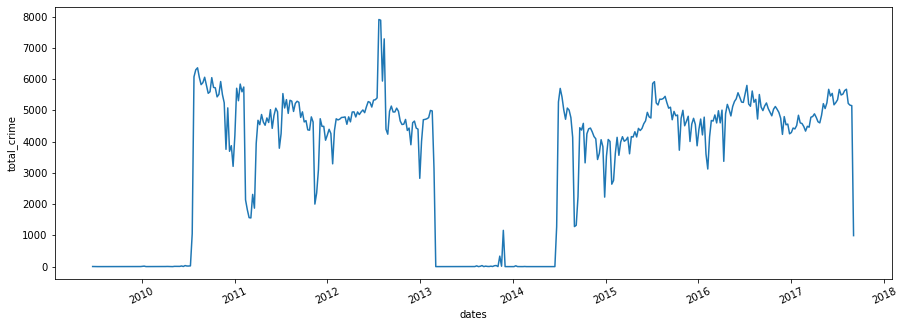

In [17]:
fig, ax = plt.subplots(figsize=(15,5), ncols=1)
sns.lineplot(x=aggregated_sum_per_week.index, y=aggregated_sum_per_week['total_crime'], ci=None)
ax.grid(False, axis='x')
plt.xticks(rotation=25);

Above is the lineplot of amount of crimes per week, scaled out by year. There are major dips in crime reports during 2009 to early 2010 , from early 2013 to early 2014, and near the end of the dataset. Upon inspection of the dataset, we can confirm that the dip at the end of the dataset is due to it being seemingly cut off at 2 days for that specific week.

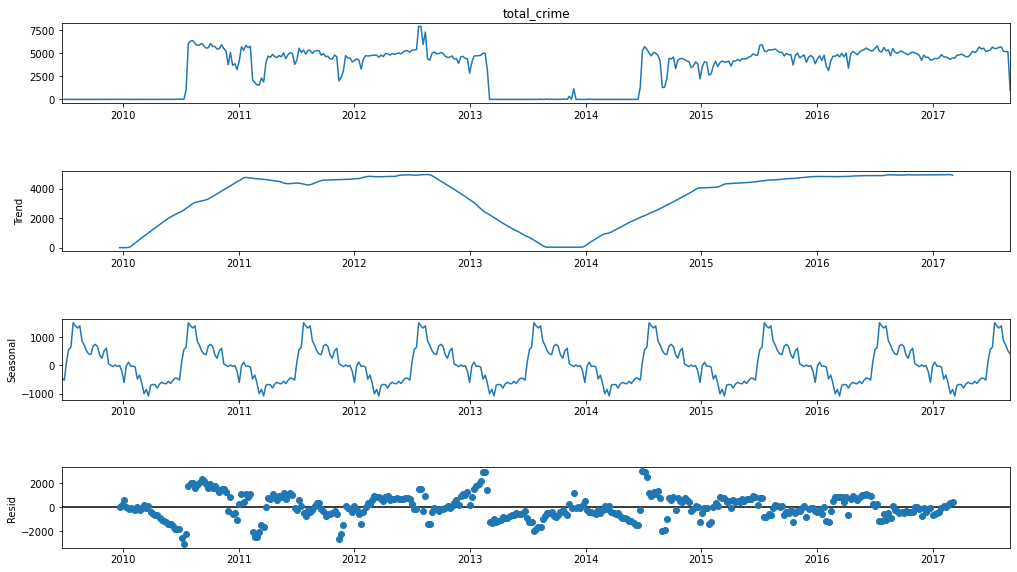

In [18]:
decomp = seasonal_decompose(aggregated_sum_per_week['total_crime'])
fig = decomp.plot()
fig.set_size_inches(16,9)

The above graphs follow the trend lines shown in the total crimes graph earlier. What's interesting to note is that there is a seasonality to the values in the dataset, wherein there is a dip in crime reports at the start of the year but spikes in the middle then peters out by the end. We can also that there is potentially a high amount of variance in the total crimes feature.

## Training Model

We shall be using an ARIMA model as our baseline model and compare its performance with an XGBoost Regressor to find which models are best fit for the job.

In [19]:
# Isolating total_crime values for time series forecasting

forecast_set = aggregated_sum_per_week['total_crime'].values
forecast_set

# forecast_set  = aggregated_sum_per_week['total_crime'].values
# forecast_set

array([3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
       2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 7.000e+00, 1.500e+01,
       1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00,
       3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
       5.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 8.000e+00, 7.000e+00,
       4.000e+00, 7.000e+00, 2.000e+01, 4.000e+00, 3.300e+01, 1.900e+01,
       1.800e+01, 2.400e+01, 1.051e+03, 6.073e+03, 6.296e+03, 6.360e+03,
       6.056e+03, 5.822e+03, 5.885e+03, 6.058e+03, 5.803e+03, 5.544e+03,
       5.593e+03, 6.045e+03, 5.734e+03, 5.719e+03, 5.430e+03, 5.509e+03,
       5.921e+03, 5.503e+03, 5.241e+03, 3.752e+03, 5.078e+03, 3.689e+03,
       3.869e+03, 3.207e+03, 4.198e+03, 5.706e+03, 

We performn Augmented Dickey Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests to confirm that our forecast set is stationary and fit for use in the ARIMA model.

In [20]:
# if p value is greater than 0.05, we fail to reject null hypothesis meaning series is non-stationary
# if p value is less than 0.05, we reject null hypothesis meaning series is stationary

result = adfuller(forecast_set)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.260088
p-value: 0.016760
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [21]:
# if p value is greater than 0.05, we fail to reject null hypothesis meaning series is stationary
# if p value is less than 0.05, we reject null hypothesis meaning series is non-stationary

print("Results of KPSS Test:")
kpsstest = kpss(forecast_set, regression="c")
kpss_output = pd.Series(
    kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
)
for key, value in kpsstest[3].items():
    kpss_output["Critical Value (%s)" % key] = value
print(kpss_output)

Results of KPSS Test:
Test Statistic            0.630440
p-value                   0.019869
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


We use ACF and PACF plots to determine the AR and MA parameters for the Auto ARIMA model.

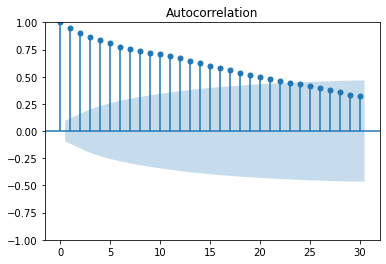

In [22]:
acf_plot = plot_acf(forecast_set, lags= 30)

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


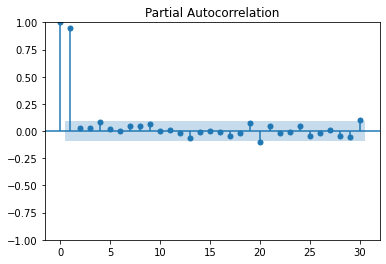

In [23]:
pacf_plot = plot_pacf(forecast_set, lags= 30)

Since ACF graph drops off slowly and the PACF graph shows a sharp cut-off early, we will be adding an AR term to the ARIMA model.

In [24]:
model = auto_arima(forecast_set, start_p=0, start_q=0,
                          max_p=1, max_q=1,m=12,start_P=0,start_Q=0, 
                          max_P = 1, max_Q = 1,
                          seasonal=True,
                          d=0,D=0,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7845.846, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6817.067, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7299.914, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8337.741, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6817.984, Time=0.02 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6819.024, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6817.245, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=7565.622, Time=0.44 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=6818.965, Time=0.19 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=7359.114, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=6822.009, Time=0.06 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 1.887 seconds


Let us check the model's performance:

In [25]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  429
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -3404.533
Date:                            Wed, 16 Feb 2022   AIC                           6817.067
Time:                                    16:32:18   BIC                           6833.313
Sample:                                         0   HQIC                          6823.483
                                            - 429                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    159.5717     82.549      1.933      0.053      -2.222     321.365
ar.L1          0.9455      0.024   

Given the aforementioned best SARIMAX parameters, let us create a SARIMAX model with them.

In [26]:
train_size = int(len(forecast_set) * 0.8)

train = forecast_set[:train_size]
test = forecast_set[train_size:]

final_model = SARIMAX(train,order=(1,0,0),seasonal_order=(1,0,0,12))
result = final_model.fit()
print(result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -2734.373
Date:                            Wed, 16 Feb 2022   AIC                           5474.745
Time:                                    16:32:19   BIC                           5486.259
Sample:                                         0   HQIC                          5479.331
                                            - 343                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9791      0.010     96.256      0.000       0.959       0.999
ar.S.L12       0.0827      0.052   

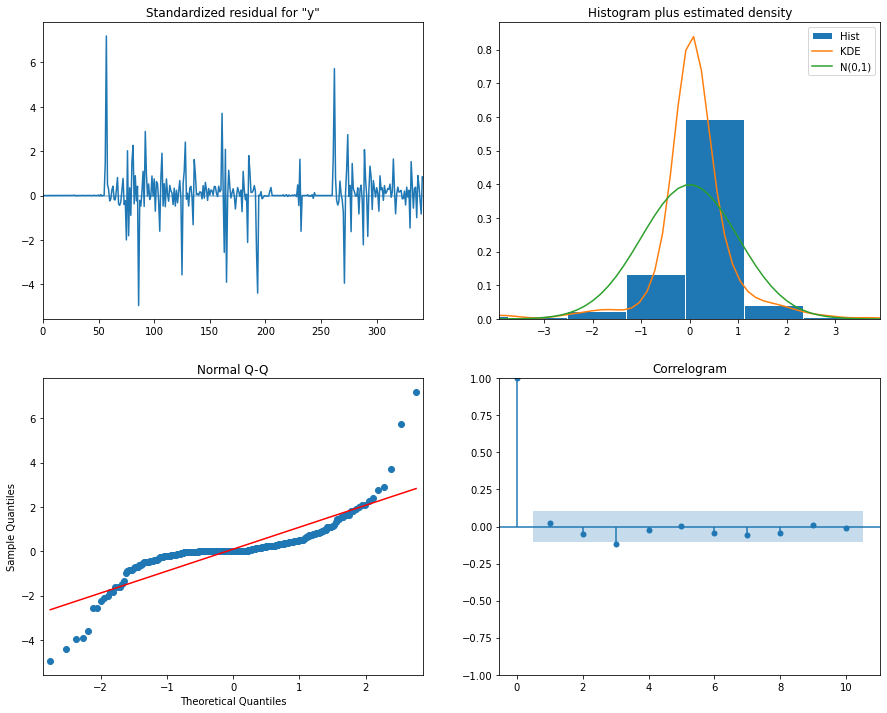

In [27]:
result.plot_diagnostics(figsize=(15, 12));

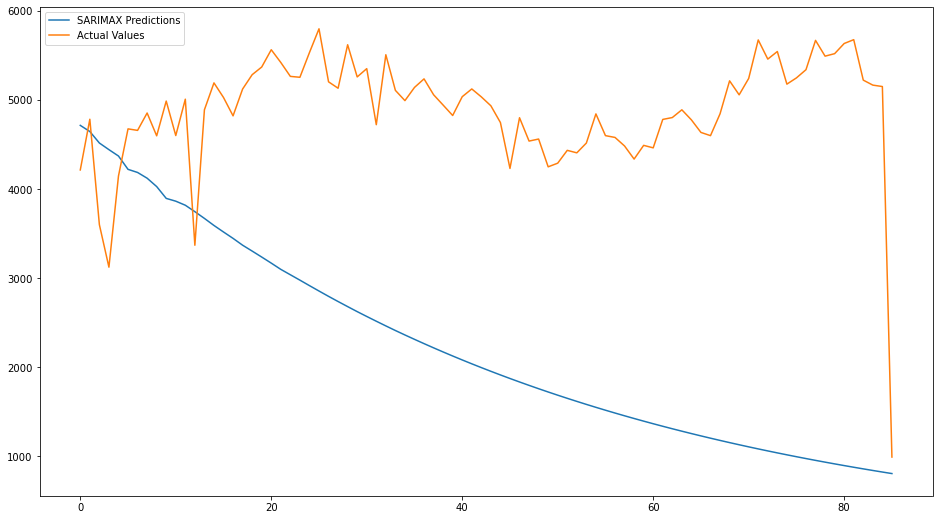

In [28]:
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels')

fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(predictions, label="SARIMAX Predictions")
plt.plot(test, label="Actual Values")
plt.legend()
plt.show()

While the diagnostics seem good, the reality is that ARIMA model may not be able to accurately predict crime reports. Now we shall experiment with the XGBoost Regressor.

We used functions for the following objectives:
- Convert our `forecast_set` from a Time Series dataset into something that can be used for Regression Problems
- Create and fit an XGBoost Regressor maximizing for MSE
- Apply Walk Forward Validation, which is to use data from the train set and predictions from the model to predict future values, as a form of validation before testing the model. This is to also assist in generating RMSE and MAE scores later for evaluation

There is a need for functions given the experimentats we performed.

In [29]:
# Creating functions based on Machine Learning Master blog's functions for Time Series Forecasting
# https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[0]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg = agg.dropna()
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
#     print(model.feature_importances_)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
#     display(test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    mae_error = mean_absolute_error(test[:, -1], predictions)
    mse_error = mean_squared_error(test[:, -1], predictions, squared=False)
    return mae_error, mse_error, test[:, -1], predictions

Our experiments focused on how far back should the model look back to make predictions on future crime report values.

In [30]:
res = list()
list_of_data = list()

# Testing values 1 - 4 weeks in the past as basis for forecasting.
for i in range(1, 5):
    print(f'Testing {i} weeks in the past')
    data = series_to_supervised(forecast_set, n_in=i)
    list_of_data.append(data)
    mae, rmse, y, yhat = walk_forward_validation(data, 16)
#     print('MAE: %.3f' % mae)
#     print('RMSE: %.3f' % rmse)
    res.append({
        'steps_back': i,
        'type': 'MAE',
        'value': mae
    })
    res.append({
        'steps_back': i,
        'type': 'RMSE',
        'value': rmse
    })
    
results = pd.DataFrame(res)
results

Testing 1 weeks in the past
>expected=5240.0, predicted=4941.0
>expected=5672.0, predicted=3752.0
>expected=5457.0, predicted=5428.0
>expected=5542.0, predicted=5242.0
>expected=5176.0, predicted=5593.0
>expected=5246.0, predicted=5357.0
>expected=5338.0, predicted=5069.0
>expected=5667.0, predicted=5398.0
>expected=5490.0, predicted=5457.0
>expected=5518.0, predicted=5241.0
>expected=5632.0, predicted=5921.0
>expected=5675.0, predicted=5257.0
>expected=5221.0, predicted=5457.0
>expected=5165.0, predicted=5290.0
>expected=5149.0, predicted=5357.0
>expected=991.0, predicted=5235.0
Testing 2 weeks in the past
>expected=5240.0, predicted=4980.7
>expected=5672.0, predicted=4914.2
>expected=5457.0, predicted=5495.9
>expected=5542.0, predicted=5188.2
>expected=5176.0, predicted=5832.2
>expected=5246.0, predicted=5567.5
>expected=5338.0, predicted=5363.5
>expected=5667.0, predicted=5231.8
>expected=5490.0, predicted=6785.7
>expected=5518.0, predicted=5533.3
>expected=5632.0, predicted=4936.1


,steps_back,type,value
0,1,MAE,590.237183
1,1,RMSE,1190.042633
2,2,MAE,612.421082
3,2,RMSE,1149.672473
4,3,MAE,503.074860
5,3,RMSE,1075.962866
6,4,MAE,553.412048
7,4,RMSE,1095.728203


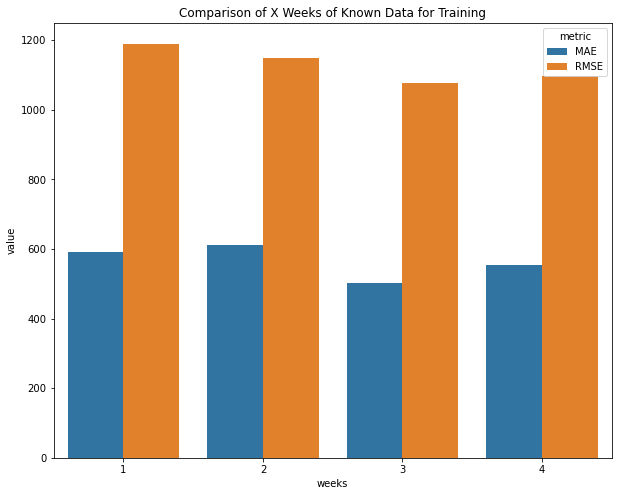

In [31]:
# Graphing results
fig, ax = plt.subplots(figsize=(10,8), ncols=1)
sns.barplot(x="steps_back", y="value", hue="type", data=results)
ax.set_title('Comparison of X Weeks of Known Data for Training')
ax.set_xlabel('weeks')
ax.legend(title='metric')

We can see that 3 weeks into the past is the best performing parameter out of the ones we tested. Intuitively, it makes sense as using the current week plus 3 weeks into the past would come out to 1 month worth of data used to predict the successive week.

As suggested we tried using a whole year to predict the next week's crime report value, to account for seasonality.

In [32]:
res = list()
list_of_data = list()

# Testing values 52 weeks in the past (1 calendar year) as basis for forecasting.

data = series_to_supervised(forecast_set, n_in=52)
list_of_data.append(data)
mae, rmse, y, yhat = walk_forward_validation(data, 16)
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

>expected=5240.0, predicted=4869.8
>expected=5672.0, predicted=5121.9
>expected=5457.0, predicted=5579.6
>expected=5542.0, predicted=5989.7
>expected=5176.0, predicted=5642.5
>expected=5246.0, predicted=5383.7
>expected=5338.0, predicted=5402.4
>expected=5667.0, predicted=5083.7
>expected=5490.0, predicted=5235.7
>expected=5518.0, predicted=5046.4
>expected=5632.0, predicted=5484.0
>expected=5675.0, predicted=5462.7
>expected=5221.0, predicted=5503.6
>expected=5165.0, predicted=5119.0
>expected=5149.0, predicted=5324.4
>expected=991.0, predicted=5326.0
MAE: 541.730
RMSE: 1131.786


However, it appears to perform worse compare to 3 weeks.

Below are some codes to further illustrate the performance of the XGBoost Regressor along with the transformed dataset fed to it.

In [33]:
# Testing predicting new data
new_data = series_to_supervised(forecast_set, n_in=3)
# split into input and output columns
X, y = new_data[:, :-1], new_data[:, -1]
# fit model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X, y)
# construct an input for a new preduction
row = forecast_set[-3:].flatten()
# row = forecast_set[-4:-1].flatten()
# make a one-step prediction
yhat = model.predict(np.asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [5165. 5149.  991.], Predicted: 1197.622


>expected=5457.0, predicted=5579.6
>expected=5542.0, predicted=5989.7
>expected=5176.0, predicted=5642.5
>expected=5246.0, predicted=5383.7
>expected=5338.0, predicted=5402.4
>expected=5667.0, predicted=5083.7
>expected=5490.0, predicted=5235.7
>expected=5518.0, predicted=5046.4
>expected=5632.0, predicted=5484.0
>expected=5675.0, predicted=5462.7
>expected=5221.0, predicted=5503.6
>expected=5165.0, predicted=5119.0
>expected=5149.0, predicted=5324.4
>expected=991.0, predicted=5326.0


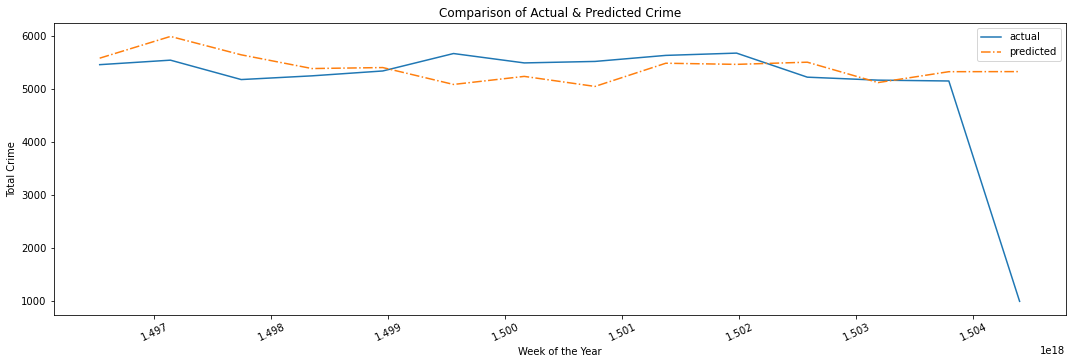

In [34]:
# Graphing performance of model using given dataset
new_data = series_to_supervised(forecast_set[:-17], n_in=3)
mae, rmse, y, yhat = walk_forward_validation(data, 14)

fig, ax = plt.subplots(figsize=(15,5), ncols=1)
sns.lineplot(x=aggregated_sum_per_week.index.values.tolist()[-14:], y=y, ci=None, ax=ax, label='actual')
sns.lineplot(x=aggregated_sum_per_week.index.values.tolist()[-14:], y=yhat, ci=None, ax=ax, label='predicted', linestyle='-.')
ax.grid(False,axis='x')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Total Crime')
ax.set_title("Comparison of Actual & Predicted Crime")
plt.tight_layout()
plt.xticks(rotation=25);
plt.show()

In [35]:
print("Actual:", y)
print("Predicted:", yhat)

Actual: [5457. 5542. 5176. 5246. 5338. 5667. 5490. 5518. 5632. 5675. 5221. 5165.
 5149.  991.]
Predicted: [5579.6177, 5989.7256, 5642.5386, 5383.696, 5402.3843, 5083.6963, 5235.7314, 5046.3633, 5484.0117, 5462.652, 5503.641, 5119.0493, 5324.382, 5325.9873]


As you can see, the XGBoost Regressor was able to more accurately follow the trend lines plotted by the actual values coming from the dataset.

# Conclusion

We found that the XGBoost Regressor is the better fit so far for this scenario of forecasting future crime reports.

We believe this model can be used for the following cases:
- Determining how much police manpower may need to be on standby for the following weeks
- In addition to the previous point, determining how much police resources can be allocated aside from manpower
- A pseudo-metric for trust in the Seattle PD as the amount of reports is also affected by trust in the PD.

We recommend the following to further improve the studies and attempts similar to this:
- the PD to record information to more accurately describe nature of 911 calls (preferably in more machine readable formats)
- Training the model to forecast amount of specific types of crimes as well as amount of crimes in certain Districts

# References

Brownlee, J. (2019, August 21). How to Convert a Time Series to a Supervised Learning Problem in Python. *Machine 
          Learning Mastery*. Retrieved from: ttps://machinelearningmastery.com/convert-time-series-supervised-learning-
          problem-python/

Brownlee, J. (2020, August 15). Time Series Forecasting as Supervised Learning. *Machine Learning Mastery*. Retrieved from: 
          https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

Brownlee, J. (2020, August 5). How to use XGBoost for Time Series Forecasting. *Machine Learning Mastery*. Retrieved from: 
          https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

Dane, S. (2018). Seattle Police Department 911 Incident Responses. *Kaggle*. Retrieved from: 
          https://www.kaggle.com/sohier/seattle-police-department-911-incident-response
          
Shweta. (2021, July 30). *Introduction to time series forecasting - part 2 (Arima models)*. Medium. Retrieved from                         https://towardsdatascience.com/introduction-to-time-series-forecasting-part-2-arima-models-9f47bf0f476b 

Westneat, D. (2021, July 10). ‘Don’t have a clue’: It turns out Washington state set a murder record in 2020, but no one 
          knows why. *The Seattle Times*. Retrieved from: https://www.seattletimes.com/seattle-news/law-justice/dont-have-a-
          clue-it-turns-out-washington-state-set-a-murder-record-in-2020-but-no-one-knows-why/